In [1]:
# import neccessary library
import tensorflow as tf
import statsmodels.api as sm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Preprocessing Data
# 1.1 Import and Cleansing Data

In [2]:
def read_cleanse_excel(file_name, file_date):
    data = pd.read_excel(file_name)

    # extract date from first column, row 5:end
    date = data.iloc[5:,0].apply(lambda x : pd.to_datetime(file_date + ' ' + str(x)))
    # extract power_kW from 16th column
    power_kW = data.iloc[5:, 16]/1e3

    # create new_frame that is exist only date and power_kW
    new_frame = pd.DataFrame([date,  power_kW])
    new_frame = new_frame.T
    new_frame.columns = ['datetime', 'power_kW']
    new_frame['datetime'] = pd.to_datetime(new_frame['datetime'])
    new_frame = new_frame.set_index(['datetime'])

    # check minor missing data
    if new_frame.shape[0] > 275 and new_frame.shape[0] < 288:
        for i in range(new_frame.shape[0]):
            # identify index of missing data
            dif = (new_frame.index[i+1] - new_frame.index[i]).seconds/60  
            if dif > 5:
                num_mis = round(dif/5 - 1) # amount of missing data

                resolution = (new_frame.iloc[i+1,0] - new_frame.iloc[i,0])/(num_mis+1)

                add_frame = pd.DataFrame({}, columns = ['datetime', 'power_kW'])
                start_new_frame = new_frame.index[i]
                start_new_value = new_frame.iloc[i,0]
                
                for k in range(int(num_mis)):
                    # add delta step 300 sec and value to add_frame
                    start_new_frame = start_new_frame + pd.Timedelta('300 s')
                    start_new_value = start_new_value + resolution
                    
                    add_time = start_new_frame
                    add_value = start_new_value
                    add_frame = pd.concat([add_frame,
                                           pd.DataFrame({'datetime':add_time, 'power_kW':add_value},
                                                        index=[0])])
                # set index to datetime
                add_frame = add_frame.set_index(['datetime'])

                # add add_frame to existing frame and sort by index
                new_frame = pd.concat([new_frame, add_frame])
                new_frame.sort_index(inplace = True)          
        return new_frame, new_frame.shape[0]
    
    # return data immediatly if this day have complete data
    elif new_frame.shape[0] == 288:
        return new_frame, new_frame.shape[0]
    
    # too much value missing return None
    else:
        return None, new_frame.shape[0]

In [3]:
## Retreive all data in the year

date_start = '2013-01-01'
date_temp = date_start
file_name = 'SolarRadiance/' + date_temp + '.xls'

num_stat = []
data, num = read_cleanse_excel(file_name, file_date = date_temp)
num_stat.append(num)

# Loop and import pv data
for i in range(364):
    date_temp = str(pd.to_datetime(date_temp) + pd.Timedelta('1 d'))[0:10]
#     print(date_temp)
               
    file_name = 'SolarRadiance/' + date_temp + '.xls'
    data_day, num = read_cleanse_excel(file_name, file_date = date_temp) 
    
    # if data_day is none, it means that too much values are vanish in this day, skip it
    if data_day is not None:
        data = pd.concat([data, data_day])
    num_stat.append(num)
    

# 1.2 Check remained missing data

In [4]:
new_frame = data.copy()
is_missing = False

for i in range(new_frame.shape[0] - 1):
            # identify index of missing data
            dif = (new_frame.index[i+1] - new_frame.index[i]).seconds/60
            if dif > 5:
                num_mis = dif/5 - 1 # amount of missing data
                print('Time i\t\t',new_frame.index[i])
                print('Time i+1\t',new_frame.index[i+1])
                
                is_missing = True

# 1.3 Remove night time 

In [5]:
# Observe some data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103968 entries, 2013-01-01 00:00:00 to 2013-12-31 23:55:00
Data columns (total 1 columns):
power_kW    51241 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [6]:
# Observe some data
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103968 entries, 2013-01-01 00:00:00 to 2013-12-31 23:55:00
Data columns (total 1 columns):
power_kW    103968 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [7]:
## Define night time by --> set(whole_day_time) - set(day_time)
'''
This cell will calculate result dataframe which merge is_daytime boolean
'''
# Group data by day
data_grouped = data.groupby(pd.Grouper(freq='D'))
group_keys = data_grouped.groups.keys()

date_start = pd.to_datetime('2013-01-01 00:00:00')
pv_day = data_grouped.get_group(date_start)
day_time = pv_day != 0

count = 0
for key in group_keys:
    
    # Some day is missing and raise an error if key is the missing day
    # so except that missing day using try, except
    try:
        pv_day_temp = data_grouped.get_group(key)
        
        # find first and last index of day time for every day
        for i in range(288):
            if abs(pv_day_temp.iloc[i,0]) > 10e-4:
                first_index = i
                break
        for i in range(287,-1,-1):
            if abs(pv_day_temp.iloc[i,0]) > 10e-4:
                last_index = i
                break
        
        day_time = pv_day_temp.copy()
        # Define is_daytime
        day_time.iloc[first_index:last_index,0] = True
        day_time.iloc[:first_index-1,0] = False
        day_time.iloc[last_index-1:,0] = False
        
        # merge is_daytime to data
        day_time.index = pv_day_temp.index
        day_time.columns = ['is_daytime']
        
        if count == 0:
            result = pd.merge(pv_day_temp, day_time, left_index=True, right_index=True)
        else:
            result = pd.concat([result,
                                pd.merge(pv_day_temp, day_time, left_index=True, right_index=True)])
        count += 1
    except KeyError:
        pass

## Visualize result
result

,power_kW,is_daytime
datetime,,
2013-01-01 00:00:00,0.0,False
2013-01-01 00:05:00,0.0,False
2013-01-01 00:10:00,0.0,False
2013-01-01 00:15:00,0.0,False
2013-01-01 00:20:00,0.0,False
2013-01-01 00:25:00,0.0,False
2013-01-01 00:30:00,0.0,False
2013-01-01 00:35:00,0.0,False
2013-01-01 00:40:00,0.0,False


In [8]:
'''
Now it's time to remove night time by removing False row of is_daytime columns!
'''
# Group result data by day
data_daytime = result.loc[result['is_daytime']==True,:]
for i in range(len(data_daytime)):
    print(data_daytime.iloc[i,0])

0.02779
0.04902
0.07209
0.09013
0.10483
0.11588
0.15139
0.17766
0.2468
0.29613
0.2903
0.25008
0.23051
0.246
0.20465
0.33846
0.29104
0.3896
0.43225
0.48315
0.40645
0.4318
0.41355
0.4048
0.23721
0.43727
0.67926
0.68114
0.68376
0.66315
0.48666
0.6279
0.77184
0.76363
0.77102
0.76127
0.76951
0.75527
0.7778
0.78982
0.77825
0.82312
0.85116
0.83391
0.84428
0.85074
0.86933
0.88647
0.88405
0.87565
0.85022
0.8615
0.88843
0.91724
0.91918
0.93611
0.94367
0.8782
0.89587
0.90388
0.895
0.89822
0.89218
0.88198
0.87061
0.85924
0.86313
0.86169
0.84476
0.83523
0.85621
0.83073
0.81769
0.88
0.82278
0.61343
0.63778
0.59696
0.56493
0.77625
0.82604
0.79431
0.70955
0.74289
0.74787
0.71471
0.68058
0.68804
0.69293
0.67692
0.66816
0.64115
0.61561
0.61498
0.595
0.57165
0.55905
0.53753
0.52064
0.50007
0.48445
0.46412
0.44122
0.42556
0.40079
0.37775
0.34109
0.31743
0.2966
0.27852
0.23355
0.20518
0.20764
0.17273
0.14705
0.13118
0.11482
0.08925
0.05322
0.0202
0.00556
0.00762
0.0138
0.01735
0.02329
0.03063
0.04189
0.053

0.94696
0.91503
0.83933
0.61695
0.49405
0.43289
0.58676
0.85587
0.77119
0.88861
0.8532
0.87879
0.83684
0.82407
0.84738
0.85635
0.79825
0.81583
0.834
0.73811
0.84423
0.77727
0.83071
0.79233
0.78529
0.59145
0.48413
0.3617
0.41811
0.40785
0.39858
0.40639
0.38692
0.37495
0.37636
0.34991
0.34684
0.34009
0.32732
0.32667
0.30853
0.28417
0.27187
0.25881
0.2397
0.22678
0.21996
0.20985
0.2034
0.20214
0.19409
0.18424
0.1685
0.14741
0.134
0.11632
0.10442
0.09411
0.07836
0.068535
0.05871
0.03834
0.02257
0.01238
0.02008
0.02659
0.01553
0.01625
0.05357
0.07684
0.13589
0.20444
0.20364
0.18402
0.14943
0.21317
0.18173
0.27734
0.31632
0.32353
0.30045
0.36283
0.38173
0.3964
0.39597
0.42107
0.42918
0.43273
0.43795
0.45246
0.47798
0.48902
0.48124
0.48667
0.51655
0.51979
0.40009
0.20441
0.55021
0.42738
0.32422
0.41085
0.51144
0.507
0.60263
0.44815
0.52473
0.45397
0.18562
0.418
0.4362
0.61609
0.64605
0.65826
0.60413
0.63446
0.63577
0.518
0.60765
0.5981
0.58405
0.60935
0.61643
0.62093
0.62373
0.59759
0.60954
0

0.54404
0.55305
0.579
0.56455
0.54983
0.54606
0.5584
0.55256
0.55
0.54511
0.51375
0.54583
0.5648
0.57163
0.53146
0.53104
0.53024
0.55104
0.53884
0.48802
0.52184
0.52109
0.51385
0.52717
0.50976
0.50235
0.4787
0.50229
0.49977
0.48215
0.47704
0.474
0.43387
0.45062
0.46175
0.33288
0.44703
0.45338
0.39471
0.38309
0.33647
0.23529
0.17004
0.1613
0.315
0.37818
0.36456
0.32446
0.28627
0.19951
0.27029
0.16438
0.13174
0.12411
0.11174
0.12502
0.12617
0.16454
0.13994
0.12276
0.09041
0.06486
0.08367
0.0778
0.0622
0.06457
0.06096
0.05281
0.0397
0.02585
0.00362
0.01528
0.02915
0.045
0.05354
0.06282
0.07832
0.09551
0.10954
0.11458
0.12641
0.13291
0.14625
0.16289
0.18512
0.2028
0.21466
0.2214
0.23584
0.25042
0.2635
0.27622
0.28653
0.30159
0.31254
0.32903
0.34015
0.35558
0.364
0.37833
0.3868
0.39743
0.40565
0.41213
0.41731
0.4325
0.43055
0.442
0.43357
0.42898
0.42239
0.42478
0.33256
0.24882
0.25044
0.23766
0.24793
0.21131
0.27531
0.504
0.32581
0.3009
0.21678
0.27104
0.27153
0.4473
0.48506
0.56085
0.57222

0.8487
0.71953
0.37504
0.40636
0.47083
0.51024
0.49517
0.44535
0.33595
0.39913
0.42604
0.28313
0.29957
0.37395
0.34029
0.32745
0.25568
0.28775
0.24929
0.21783
0.24051
0.25575
0.23424
0.15882
0.15991
0.14835
0.14718
0.14118
0.12574
0.1008
0.08058
0.06286
0.05443
0.04695
0.02908
0.01271
0.0229
0.02783
0.03298
0.04391
0.06013
0.07389
0.08541
0.10057
0.11847
0.13998
0.15395
0.1708
0.17995
0.18994
0.20435
0.21096
0.22292
0.23493
0.25731
0.27559
0.30668
0.33345
0.36458
0.38091
0.4039
0.45169
0.47051
0.5132
0.52391
0.57945
0.56457
0.66651
0.63816
0.57642
0.47937
0.52473
0.49245
0.61348
0.59537
0.7747
0.79885
0.67171
0.70446
0.67865
0.69755
0.59367
0.62689
0.76196
0.77771
0.7709
0.73202
0.66348
0.58779
0.59073
0.61464
0.62874
0.6413
0.6583
0.60939
0.5922
0.61907
0.62498
0.61245
0.58789
0.58313
0.57251
0.56983
0.55872
0.56652
0.54615
0.5492
0.47969
0.48824
0.47546
0.43502
0.42394
0.41989
0.40532
0.42829
0.46923
0.66566
0.64582
0.72928
0.54193
0.70725
0.70624
0.80414
0.53618
0.49989
0.43992
0.42

0.8083
0.46538
0.45507
0.32513
0.34052
0.39593
0.43189
0.536
0.31706
0.54538
0.40851
0.40703
0.31245
0.70218
0.64322
0.2299
0.20609
0.22091
0.59119
0.81833
0.49333
0.74259
0.90218
0.83546
0.74237
0.3862
0.2888
0.67253
0.39739
0.46202
0.34491
0.27071
0.26543
0.26962
0.44579
0.2008
0.19993
0.48911
0.42263
0.34188
0.04115
0.00559
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0003
0.0
0.01473
0.0994
0.15922
0.26
0.28949
0.56509
0.52522
0.36564
0.47277
0.43815
0.38515
0.3261
0.28536
0.23791
0.20113
0.17626
0.14825
0.11025
0.09804
0.07428
0.00869
0.02193
0.02936
0.04105
0.0564
0.06441
0.07879
0.09518
0.10945
0.12613
0.14388
0.1637
0.18588
0.20457
0.21879
0.24161
0.22985
0.25498
0.30465
0.31804
0.29572
0.34004
0.34595
0.27831
0.25391
0.32446
0.34362
0.48746
0.51835
0.49831
0.52796
0.54253
0.57838
0.58784
0.53158
0.64346
0.52798
0.6622
0.69289
0.69787
0.70785
0.69035
0.70913
0.48929
0.65338
0.12721
0.11178
0.09093
0.05893
0.13548
0.22859
0.19219
0.32022
0.84796
0.89308
0.86976
0.87152
0.87787
0.90205
0.89508


0.4463
0.43593
0.41745
0.34144
0.32147
0.32938
0.33729
0.31286
0.30275
0.28729
0.26193
0.23713
0.21521
0.19366
0.17057
0.15078
0.13227
0.10326
0.07221
0.05105
0.02986
0.00938
0.02071
0.03042
0.05382
0.07402
0.07688
0.084
0.11233
0.14007
0.17734
0.2021
0.23331
0.32475
0.24369
0.33011
0.35895
0.40422
0.39807
0.42353
0.47298
0.49971
0.45764
0.29763
0.35102
0.27713
0.31736
0.18541
0.1849
0.37869
0.55159
0.53293
0.28876
0.51613
0.61031
0.68998
0.66256
0.65424
0.75176
0.79552
0.78361
0.79832
0.54623
0.56198
0.75268
0.74216
0.79754
0.77552
0.80995
0.8106
0.79667
0.78293
0.85338
0.80888
0.74088
0.81385
0.808
0.8926
0.89274
0.90444
0.8823
0.87478
0.89484
0.91483
0.91406
0.92898
0.92143
0.91714
0.90807
0.86949
0.85622
0.81814
0.84593
0.88324
0.90511
0.89943
0.90575
0.89391
0.89163
0.87329
0.88527
0.87844
0.81111
0.76463
0.75344
0.75934
0.75767
0.77693
0.78711
0.77713
0.76534
0.75567
0.75812
0.74911
0.75536
0.73964
0.74817
0.742
0.71822
0.71067
0.68894
0.67293
0.6512
0.64608
0.60831
0.58729
0.572

0.75503
0.72512
0.67566
0.68133
0.70176
0.68026
0.66066
0.64187
0.61417
0.62863
0.61493
0.60287
0.5689
0.54288
0.53302
0.5123
0.50528
0.49645
0.48422
0.4595
0.44029
0.41989
0.40768
0.38752
0.37389
0.35425
0.32648
0.3072
0.29653
0.28189
0.27383
0.26215
0.24339
0.22262
0.21048
0.18583
0.17581
0.16373
0.14734
0.12562
0.09893
0.07679
0.05742
0.03538
0.01689
0.04034
0.05627
0.06521
0.08193
0.11262
0.10293
0.0757
0.0436
0.05262
0.04093
0.00689
0.03518
0.0349
0.0516
0.08513
0.08505
0.06869
0.03209
0.01632
0.00092
0.0
0.08177
0.16162
0.2302
0.2638
0.29291
0.30384
0.30884
0.3263
0.32288
0.32305
0.34579
0.40015
0.44227
0.45929
0.52382
0.55433
0.54729
0.47885
0.46898
0.55402
0.57391
0.55434
0.46484
0.52514
0.49753
0.61793
0.68725
0.78416
0.85736
0.78346
0.79338
0.671
0.71288
0.74802
0.59192
0.47469
0.47032
0.48963
0.52073
0.47077
0.4334
0.44329
0.46285
0.45744
0.523
0.54789
0.59289
0.60707
0.77538
0.94865
0.56223
0.87788
0.95947
1.02209
1.07466
0.98387
0.85192
0.84119
0.76803
0.43021
0.52924
0.59

0.72395
0.69393
0.68722
0.66606
0.65684
0.64796
0.63619
0.61628
0.59443
0.58724
0.58517
0.56378
0.56061
0.53809
0.5424
0.46833
0.41739
0.41762
0.40268
0.41407
0.40295
0.38295
0.35841
0.324
0.31543
0.28146
0.26911
0.23876
0.20873
0.20071
0.14726
0.10541
0.08674
0.0781
0.05485
0.04009
0.03285
0.02016
0.01119
0.00756
0.02613
0.03896
0.05882
0.07777
0.10261
0.11539
0.13676
0.16117
0.16119
0.19662
0.20491
0.18233
0.2352
0.28596
0.26887
0.32229
0.41856
0.36107
0.31789
0.46077
0.4467
0.42967
0.45465
0.27265
0.21346
0.34863
0.44383
0.58197
0.60061
0.62859
0.64131
0.64211
0.66329
0.67906
0.69057
0.71013
0.72818
0.53918
0.32794
0.74998
0.8062
0.84312
0.6956
0.24398
0.86121
0.86887
0.64522
0.84818
0.78433
0.57407
0.82218
0.4504
0.53278
0.88741
0.8761
0.88746
0.89674
0.87818
0.87658
0.71969
0.54216
0.30411
0.82019
0.7752
0.93911
0.90722
0.7062
0.89665
0.90943
0.89046
0.89717
0.90109
0.88282
0.87958
0.86788
0.86763
0.87076
0.86578
0.85785
0.84906
0.83841
0.83372
0.82796
0.81707
0.80694
0.81021
0.80

0.60476
0.91084
0.68871
0.53956
0.972
0.50311
0.59114
1.02957
0.54015
0.49985
0.78911
0.81527
0.89411
0.65373
0.64309
0.70852
0.63087
0.72238
0.53876
0.73994
0.4832
0.5975
0.74362
0.77571
0.85819
0.76573
0.83305
0.44759
0.64778
0.82828
0.81757
0.7982
0.70218
0.3787
0.71607
0.77834
0.8135
0.60739
0.6453
0.69751
0.72272
0.7147
0.45588
0.52744
0.51827
0.48983
0.6382
0.61169
0.5625
0.54186
0.54011
0.49183
0.49
0.473
0.42453
0.44682
0.43057
0.40653
0.38415
0.35895
0.34802
0.32579
0.31742
0.29908
0.26591
0.20704
0.16256
0.13535
0.10136
0.07206
0.05485
0.0423
0.02838
0.01763
0.01282
0.00624
0.02005
0.03225
0.04555
0.037
0.03447
0.04325
0.09206
0.15206
0.2034
0.20809
0.21823
0.24041
0.25222
0.24688
0.25438
0.34938
0.38004
0.39993
0.38328
0.29292
0.512
0.5616
0.59014
0.54522
0.53322
0.56541
0.57571
0.57962
0.58713
0.57854
0.61432
0.54963
0.53653
0.55505
0.63627
0.68078
0.66896
0.72738
0.74555
0.4972
0.76638
0.76896
0.80402
0.7314
0.72645
0.96702
0.49696
0.44266
0.53371
0.52277
0.58945
0.56883
0

0.21786
0.07578
0.05852
0.0435
0.0287
0.05263
0.06647
0.03724
0.04294
0.05623
0.02783
0.03891
0.0553
0.07723
0.10105
0.09567
0.1128
0.12469
0.14371
0.13831
0.12902
0.21222
0.15918
0.12355
0.09584
0.06302
0.04896
0.01855
0.01833
0.02092
0.00672
0.006
0.00849
0.014
0.00815
0.006
0.00703
0.01342
0.01909
0.02202
0.02202
0.00938
0.00207
0.0082
0.0131
0.01935
0.02827
0.04594
0.06496
0.0748
0.07593
0.07691
0.0925
0.106
0.12616
0.13657
0.14407
0.16049
0.1936
0.20884
0.23447
0.26284
0.12898
0.27581
0.26978
0.2402
0.30061
0.40153
0.38493
0.41031
0.42503
0.45918
0.48338
0.51471
0.52876
0.54346
0.54573
0.57041
0.58295
0.60122
0.61413
0.62977
0.64684
0.66689
0.67453
0.71867
0.55114
0.44281
0.80455
0.60737
0.24291
0.18036
0.16931
0.50377
0.36785
0.33228
0.58285
0.83762
0.64614
0.74121
0.5968
0.29819
0.27212
0.17208
0.65939
0.29457
0.19891
0.17811
0.51463
0.31667
0.39154
0.18373
0.22333
0.2232
0.25096
0.76973
0.68617
0.50785
0.88139
0.387
0.52335
0.39402
0.31557
0.4057
0.51983
0.43902
0.23249
0.20223

0.02687
0.00933
0.002
0.0
0.006
0.00642
0.00751
0.01544
0.03069
0.05523
0.06596
0.07407
0.08144
0.088325
0.09521
0.098
0.10885
0.11838
0.11752
0.10291
0.10411
0.09829
0.10219
0.10916
0.11661
0.10525
0.09131
0.1093
0.1904
0.23636
0.26272
0.2705
0.27185
0.28634
0.32831
0.3312
0.36144
0.38343
0.46896
0.51382
0.51194
0.47723
0.51213
0.51284
0.46866
0.4647
0.44016
0.44791
0.46898
0.32455
0.32364
0.39698
0.46712
0.37735
0.46196
0.49049
0.50072
0.48022
0.48622
0.4793
0.46169
0.40982
0.4808
0.45043
0.44247
0.41348
0.34513
0.40295
0.51358
0.52368
0.40011
0.40176
0.34223
0.41552
0.45568
0.37746
0.51265
0.54082
0.57294
0.54765
0.54368
0.43412
0.35553
0.37524
0.35913
0.26993
0.33849
0.42273
0.41817
0.34589
0.26702
0.24862
0.25192
0.2537
0.2725
0.24852
0.24309
0.23447
0.23136
0.25736
0.26329
0.19069
0.19038
0.18529
0.24805
0.23856
0.19545
0.2182
0.22847
0.209
0.17122
0.1532
0.18927
0.15883
0.19529
0.1583
0.14515
0.1361
0.09989
0.09916
0.11
0.11538
0.09211
0.07429
0.07813
0.0815
0.00286
0.01557
0.02

0.55478
0.34727
0.40257
0.40763
0.86434
0.90533
0.41522
0.54348
0.33851
0.27298
0.30733
0.22996
0.60959
0.69907
0.7984
0.88788
0.51807
0.34522
0.46881
0.69164
0.90204
0.84591
0.87233
0.85169
0.67795
0.76673
0.66813
0.72088
0.56
0.74682
0.58204
0.34909
0.23963
0.14894
0.12333
0.12162
0.11273
0.26008
0.74265
0.64072
0.29746
0.20564
0.14752
0.15135
0.20324
0.29074
0.27996
0.23435
0.17087
0.08133
0.0428
0.01402
0.0
0.0
0.00038
0.0
0.02298
0.03656
0.04449
0.03892
0.00685
0.0161
0.02516
0.03511
0.04144
0.04592
0.04788
0.0354
0.03038
0.03117
0.03466
0.0694
0.0877
0.08986
0.09027
0.08972
0.0946
0.1083
0.11373
0.10898
0.12115
0.12622
0.1388
0.15233
0.16891
0.18423
0.21229
0.22855
0.24818
0.26705
0.27836
0.28578
0.29075
0.30313
0.30951
0.30373
0.28442
0.285
0.33033
0.38421
0.42383
0.4782
0.50282
0.44582
0.27771
0.1673
0.13491
0.32146
0.391
0.38168
0.40162
0.39815
0.40922
0.40563
0.35595
0.31644
0.25379
0.23506
0.22472
0.31652
0.33378
0.3007
0.2951
0.24125
0.23008
0.28149
0.27385
0.28018
0.30326


0.04611
0.03087
0.00283
0.01087
0.01824
0.02828
0.04269
0.0598
0.0703
0.0798
0.09522
0.10658
0.12282
0.1273
0.13578
0.14073
0.16822
0.178
0.15286
0.21143
0.18367
0.20057
0.23943
0.26854
0.23836
0.21353
0.21704
0.21707
0.23461
0.27456
0.31088
0.33029
0.40208
0.46962
0.45867
0.53475
0.56456
0.40378
0.49853
0.54061
0.64727
0.65516
0.51352
0.53904
0.50239
0.54324
0.57378
0.49374
0.61603
0.6935
0.74874
0.71307
0.4843
0.4488
0.60087
0.4725
0.48652
0.39296
0.55162
0.50182
0.42245
0.25986
0.14929
0.21625
0.1894
0.15515
0.16573
0.06765
0.11346
0.18041
0.16111
0.06229
0.06749
0.09795
0.14053
0.23204
0.18092
0.1018
0.08324
0.12032
0.15658
0.22065
0.437
0.33009
0.1359
0.1124
0.15085
0.12573
0.06019
0.07482
0.06719
0.07084
0.11273
0.17524
0.16337
0.23504
0.20267
0.60142
0.39065
0.12367
0.15954
0.203
0.38393
0.44222
0.38124
0.44442
0.39425
0.36409
0.32695
0.33264
0.30791
0.26447
0.36752
0.44044
0.39642
0.45417
0.32031
0.26449
0.31311
0.25929
0.20547
0.18058
0.17109
0.16538
0.17911
0.22833
0.188
0.12

0.75663
0.5758
0.82564
0.54793
0.52511
0.69828
0.65153
0.66259
0.51768
0.79827
0.94763
1.00424
0.98682
0.93987
0.91691
0.58733
0.68885
0.71625
0.75461
0.54271
0.82108
0.77783
0.69136
0.76279
0.66871
0.21263
0.30524
0.32977
0.38135
0.46124
0.20622
0.24861
0.47124
0.43366
0.37988
0.42672
0.35054
0.29956
0.36876
0.41073
0.40427
0.40307
0.36854
0.34904
0.33564
0.3128
0.24661
0.19721
0.16835
0.17344
0.17046
0.18949
0.15585
0.11753
0.10334
0.09645
0.09436
0.08355
0.06646
0.04795
0.03904
0.03079
0.01984
0.00993
0.01878
0.03017
0.04552
0.06571
0.08298
0.11678
0.12977
0.1355
0.14676
0.12838
0.12559
0.13452
0.14955
0.1729
0.19542
0.20714
0.25932
0.30787
0.30816
0.3303
0.3509
0.36323
0.42911
0.364
0.34276
0.42069
0.47095
0.0
0.34115
0.32041
0.32034
0.31827
0.35569
0.38813
0.3814
0.4115
0.45211
0.49195
0.66661
0.67009
0.6298
0.597
0.50149
0.498455
0.49542
0.4514
0.40983
0.48931
0.59245
0.50356
0.43341
0.35267
0.33411
0.27724
0.336
0.4452
0.542
0.42357
0.3606
0.35947
0.26085
0.34675
0.71382
0.54927

0.12261
0.13524
0.14785
0.1794
0.25269
0.26367
0.27194
0.30165
0.25889
0.18038
0.12874
0.13913
0.1908
0.17873
0.15936
0.08393
0.07787
0.08677
0.10143
0.12887
0.13827
0.12158
0.12386
0.14041
0.14595
0.14393
0.1403
0.13845
0.13083
0.15055
0.21422
0.28294
0.31398
0.33682
0.34843
0.38487
0.41126
0.46278
0.55124
0.66533
0.63667
0.49979
0.40893
0.34685
0.29502
0.24804
0.20914
0.17726
0.15495
0.14098
0.14525
0.20108
0.31698
0.439
0.59735
0.82033
0.85057
0.85865
0.98207
0.79855
0.75565
0.63559
0.41795
0.27871
0.24142
0.28671
0.40664
0.74853
0.66494
0.54047
0.40662
0.31442
0.29771
0.34624
0.39012
0.42869
0.44853
0.44847
0.43421
0.4661
0.43129
0.4448
0.45939
0.41869
0.41091
0.38991
0.36087
0.28495
0.21173
0.16627
0.15638
0.14854
0.14086
0.13318
0.11053
0.0961
0.08868
0.08945
0.10126
0.11086
0.11291
0.12496
0.14285
0.16105
0.15693
0.1414
0.16145
0.15146
0.12985
0.11555
0.09228
0.08143
0.06522
0.08033
0.06824
0.06348
0.05857
0.04685
0.04368
0.00131
0.01586
0.0
0.0
0.00033
0.0
0.0823
0.17025
0.2184

0.214
0.1907
0.18329
0.18665
0.16645
0.11917
0.07538
0.03448
0.0185
0.01584
0.00256
0.02309
0.03342
0.04519
0.0681
0.08629
0.10821
0.13038
0.15073
0.17034
0.17919
0.19818
0.18829
0.2309
0.21935
0.21416
0.32154
0.36542
0.39246
0.4152
0.44567
0.45581
0.43527
0.18567
0.45063
0.37172
0.37383
0.37738
0.60222
0.54161
0.49755
0.52104
0.49517
0.48203
0.35162
0.71891
0.45247
0.5661
0.40584
0.68072
0.66915
0.42955
0.22483
0.54502
0.9037
0.67576
0.87133
0.84111
0.88742
0.71929
0.42807
0.84417
0.69464
0.66196
0.45453
0.5148
0.50669
0.35267
0.56073
0.86775
0.61621
0.63218
0.71402
1.01363
0.58411
0.19032
0.33186
0.84719
0.9441
0.85564
0.8248
0.93228
0.18556
0.17276
0.57393
0.96838
0.35811
0.68533
0.93989
0.57691
0.21158
0.24302
0.84595
0.6536
0.23783
0.20711
0.34227
0.35529
0.43907
0.344
0.20945
0.1798
0.20751
0.25205
0.16578
0.16453
0.48886
0.24824
0.28607
0.54693
0.51965
0.60906
0.62231
0.32576
0.54735
0.54579
0.47511
0.48826
0.45962
0.44976
0.42911
0.40993
0.38921
0.36264
0.36749
0.34327
0.328
0.

0.53509
0.53998
0.513
0.59604
0.61157
0.60885
0.62307
0.6494
0.66246
0.68195
0.6683
0.71193
0.73796
0.73632
0.74863
0.76164
0.76289
0.77911
0.80661
0.69327
0.22859
0.38309
0.86964
0.72412
0.45793
0.53535
0.7029
0.8691
0.856
0.93293
0.93906
0.81748
0.83758
0.91081
0.37927
0.28997
0.37473
0.33567
0.86258
0.98216
0.63686
0.77665
0.94165
0.68146
0.62004
0.95553
0.68153
0.9745
0.85357
0.97125
0.87626
0.89258
0.27515
0.18513
0.19971
0.87222
0.79517
0.6793
0.79657
0.69057
0.58903
0.52908
0.54107
0.35026
0.7576
0.79131
0.80245
0.35853
0.24242
0.57138
0.75381
0.7345
0.71769
0.69429
0.49645
0.29861
0.15149
0.10968
0.09007
0.08865
0.10925
0.52311
0.40127
0.23724
0.19718
0.36802
0.41707
0.379
0.32963
0.28736
0.21311
0.07
0.0035
0.02014
0.03261
0.04905
0.06928
0.0943
0.11619
0.1352
0.15693
0.1864
0.20815
0.23833
0.25735
0.295
0.32291
0.3334
0.3543
0.376
0.38795
0.39548
0.42622
0.4376
0.45598
0.50158
0.53848
0.55769
0.26004
0.13985
0.63022
0.67553
0.6462
0.63337
0.7505
0.76765
0.50775
0.60194
0.1281

0.34991
0.37884
0.38988
0.42693
0.44957
0.4721
0.49693
0.50704
0.50665
0.51363
0.51319
0.5194
0.55334
0.55691
0.53627
0.54404
0.54677
0.56565
0.60645
0.6349
0.61798
0.6226
0.617
0.62384
0.67767
0.68745
0.67164
0.58383
0.54817
0.59674
0.60558
0.58493
0.75073
0.82492
0.82665
0.82709
0.80722
0.797
0.81269
0.82051
0.80691
0.83735
0.8423
0.84635
0.82482
0.89904
0.90361
0.72129
0.48918
0.80469
0.76902
0.8552
0.85941
0.84846
0.67164
0.71653
0.55974
0.55641
0.2961
0.57902
0.65742
0.62182
0.54018
0.53395
0.39375
0.4201
0.57616
0.53029
0.54947
0.54584
0.52098
0.52729
0.55344
0.55148
0.39604
0.1929
0.1874
0.24958
0.32949
0.31845
0.23518
0.18098
0.19989
0.2958
0.23074
0.31108
0.30711
0.25073
0.16441
0.1375
0.15086
0.16671
0.17213
0.14955
0.14343
0.12259
0.10085
0.0835
0.07422
0.06684
0.05839
0.04374
0.03687
0.02676
0.01547
0.00625
0.01706
0.02542
0.03446
0.03719
0.04753
0.0604
0.0693
0.08698
0.11496
0.1517
0.196
0.23925
0.27252
0.30257
0.3202
0.3338
0.36121
0.38953
0.40946
0.43414
0.45119
0.4656
0

0.25829
0.28171
0.30123
0.3184
0.33247
0.35191
0.36958
0.38954
0.41318
0.42903
0.46156
0.4718
0.49251
0.51411
0.53875
0.54871
0.57794
0.59249
0.6167
0.62729
0.64659
0.65952
0.68081
0.68339
0.71233
0.7235
0.729
0.75112
0.72804
0.69642
0.74171
0.73995
0.72665
0.7466
0.73717
0.73405
0.719
0.71249
0.72572
0.742755
0.75979
0.78809
0.78346
0.7948
0.79103
0.77054
0.75553
0.75773
0.76989
0.78095
0.78693
0.79733
0.8028
0.79154
0.82942
0.83798
0.82431
0.81009
0.73496
0.73549
0.77368
0.72693
0.688
0.75998
0.75605
0.73361
0.72225
0.68253
0.67655
0.65998
0.63873
0.57409
0.61702
0.56602
0.53384
0.5437
0.51729
0.54462
0.4856
0.4235
0.427405
0.43131
0.46913
0.49038
0.46642
0.46078
0.43027
0.39368
0.26618
0.20985
0.1951
0.23885
0.27787
0.2672
0.2232
0.22592
0.1826
0.17075
0.1357
0.09463
0.07153
0.07002
0.06456
0.05928
0.05371
0.03876
0.03028
0.02426
0.00246
0.01308
0.02355
0.03505
0.04693
0.0596
0.07071
0.083
0.10073
0.11654
0.13857
0.17398
0.20189
0.2189
0.24836
0.27354
0.30402
0.32887
0.35573
0.37583

0.77748
0.77284
0.79266
0.78474
0.7954
0.8083
0.79715
0.78211
0.78887
0.7888
0.78656
0.79073
0.84394
0.8374
0.84417
0.84235
0.81082
0.81276
0.81419
0.80627
0.81767
0.79562
0.78766
0.7876
0.78902
0.77627
0.74906
0.75628
0.75758
0.74393
0.74147
0.72346
0.70715
0.69842
0.6373
0.5885
0.60502
0.66344
0.65864
0.63771
0.61741
0.61223
0.54855
0.56987
0.56098
0.53772
0.51413
0.4708
0.44227
0.41815
0.38206
0.39005
0.36889
0.34263
0.31484
0.30711
0.28698
0.26056
0.2436
0.21833
0.19211
0.16864
0.16335
0.14565
0.12325
0.10884
0.09107
0.07581
0.06126
0.04731
0.03273
0.02022


(0, 500)

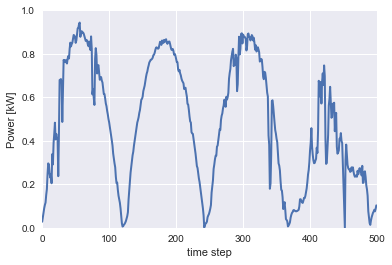

In [9]:
# Visualize suk nid

steps = 500
y = data_daytime.iloc[:steps,0]
x = np.arange(steps)
plt.plot(x,y, linewidth='2')

plt.xlabel('time step')
plt.ylabel('Power [kW]')
plt.ylim([0,1])
plt.xlim([0,500])

<em> Finally night time is removed! </em>

# 2. Preprocessing 2

# 2.1 Categorize sunny, cloudy and rainy day

In [10]:
'''
This part will categorize sunny, cloudy and rainy day using k-means clustering
First we will observe data on sunny day, cloudy day and rainy day manually
'''

data_daytime_grouped = data_daytime.groupby(pd.Grouper(freq='D'))

# energy by day
avg = data_daytime_grouped.sum()/12
avg.columns = ['Energy_kWh']

# standard by day
std = data_daytime_grouped.std()
std.columns = ['std']

mean = data_daytime_grouped.mean()
max_ = data_daytime_grouped.max().iloc[:,0]

# load factor by day
lf_val = np.divide(mean.as_matrix(), max_.as_matrix())
lf = mean.copy()
lf.columns = ['Load_Factor']
lf['Load_Factor'] = lf_val


# max power change rate
group_keys = data_daytime_grouped.groups.keys()
p_ramp = lf.copy()
p_ramp.columns = ['ramp']

count = 0
for key in group_keys:
    
    # Some day is missing and raise an error if key is the missing day
    # so except that missing day using try, except
    try:
        pv_daytime = data_daytime_grouped.get_group(key)
        pv_t = np.array(pv_daytime.iloc[:-1,0])
        pv_t_1= np.array(pv_daytime.iloc[1:,0])
        max_ramp = np.max(np.abs(pv_t-pv_t_1))
#         print(p_ramp)
        p_ramp.iloc[count,0] = max_ramp
        count += 1
        
    except KeyError:
        count += 1

p_ramp = p_ramp.dropna()
lf = lf.dropna()
std = std.dropna()
avg = avg.dropna()
## End cal p_ramp

idx_dict = {'max_val':0, 'max_index':0, 'min_val':500, 'min_index':0}

for idx in range(len(avg)):
    
    if avg.iloc[idx,0] > idx_dict['max_val']:
        idx_dict['max_val'] = avg.iloc[idx,0]
        idx_dict['max_index'] = avg.index[idx]
        
    if avg.iloc[idx,0] < idx_dict['min_val']:
        idx_dict['min_val'] = avg.iloc[idx,0]
        idx_dict['min_index'] = avg.index[idx]
        

Max Day std 0.3138031912941027
Min Day std 0.04108009564891512


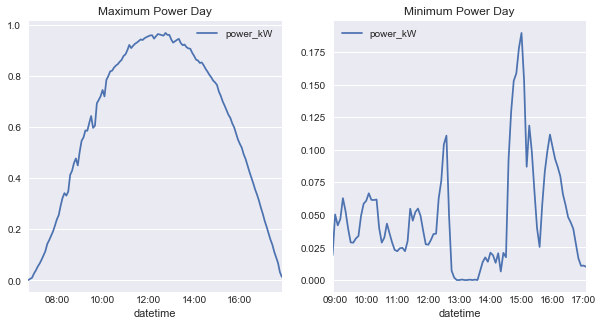

In [11]:
'''
from idx_dict, let's plot profile of min energy day and max energy day
'''

fig, ax = plt.subplots(1,2, figsize=(10,5))
data_daytime_grouped.get_group(idx_dict['max_index']).plot(y=['power_kW'],
                                                           ax = ax[0],
                                                           title='Maximum Power Day')
print('Max Day std', data_daytime_grouped.get_group(idx_dict['max_index'])['power_kW'].std())
data_daytime_grouped.get_group(idx_dict['min_index']).plot(y=['power_kW'],
                                                           ax = ax[1],
                                                           title='Minimum Power Day')
print('Min Day std', data_daytime_grouped.get_group(idx_dict['min_index'])['power_kW'].std())

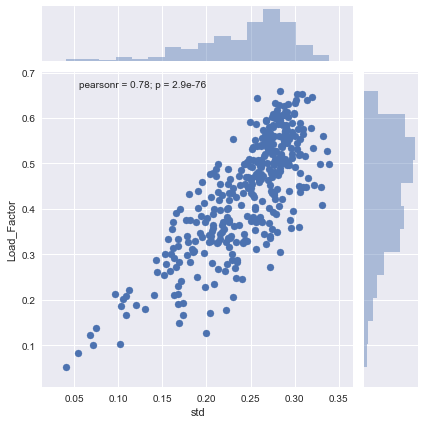

In [12]:
sns.jointplot(std.iloc[:,0],lf.iloc[:,0])

<bold> From Energy kWh vs std Plot ...</bold>

In [15]:
# combine avg and std
avg_std = pd.merge(avg, std, left_index = True, right_index=True)
avg_std_lf = pd.merge(avg_std, lf, left_index = True, right_index=True)
avg_std_ramp =pd.merge(avg_std, p_ramp, left_index = True, right_index=True)
avg_ramp = pd.merge(avg, p_ramp, left_index = True, right_index=True)
avg_std_lf_ramp = pd.merge(avg_std_lf, p_ramp, left_index = True, right_index=True)

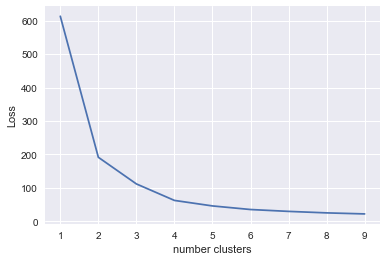

In [18]:
from sklearn.cluster import KMeans

X = avg_std_lf_ramp.loc[np.logical_not(avg['Energy_kWh'].isnull()),:].as_matrix()
X = X.reshape(X.shape[0],-1)

loss_arr = []
for i in range(1,10):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    loss_arr.append(kmeans.inertia_)

plt.plot(np.arange(n_clusters)+1, loss_arr)
plt.xlabel('number clusters')
plt.ylabel('Loss')

In [24]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters).fit(X)

group_clus = kmeans.predict(X)
print(kmeans.inertia_)
# avg = avg.dropna()

62.7093939117


In [25]:
all_group = []
for i in range(n_clusters):
    
    all_group.append(avg.index[group_clus==i])
    print('group_{:d} size: {:d}'.format(i, all_group[i].shape[0]))

group_0 size: 102
group_1 size: 99
group_2 size: 39
group_3 size: 121


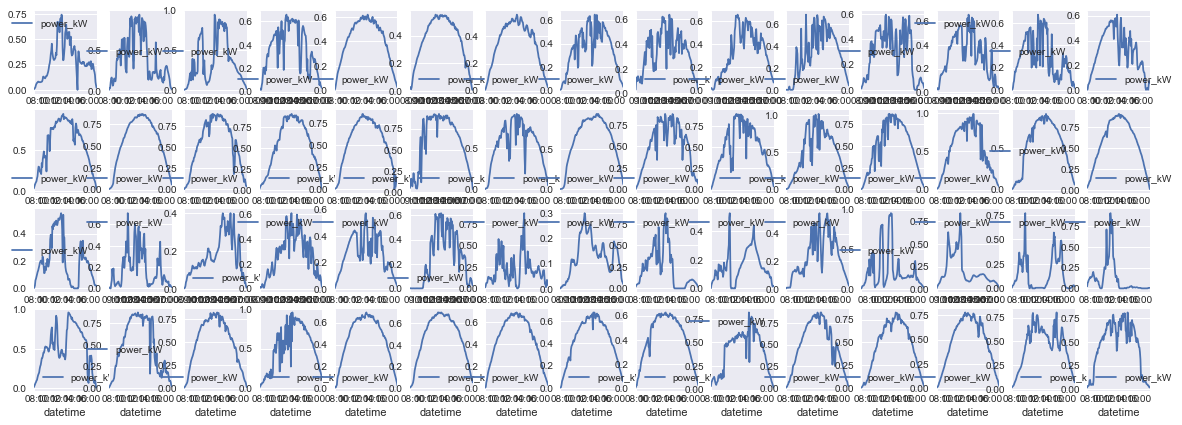

In [26]:
num_plot = 15
fig, ax = plt.subplots(n_clusters,num_plot, figsize=(20,7))

for i in range(num_plot):
    for k in range(len(all_group)):
        data_daytime_grouped.get_group(all_group[k][i]).plot(y = 'power_kW', ax=ax[k,i])

<strong> Now Each cluster can be represented as sunny, rainy and cloudy day! </strong>

In [27]:
# extract data of each group from all group
# data group
data_group_all = []

for i in range(n_clusters):
    
    # extract data from each group
    data_group_i = data_daytime_grouped.get_group(all_group[i][0])
    for k in range(all_group[i].shape[0]-1):
        data_group_i =  pd.concat([data_group_i, data_daytime_grouped.get_group(all_group[i][k+1])])
        
    data_group_all.append(data_group_i)
    
data_group_all[n_clusters-1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15288 entries, 2013-01-06 07:30:00 to 2013-12-31 17:25:00
Data columns (total 2 columns):
power_kW      15288 non-null float64
is_daytime    15288 non-null object
dtypes: float64(1), object(1)
memory usage: 358.3+ KB


# 2.2 Prepare input and output of time-series
<em> Create Method for prepare input and output of time series </em>

In [28]:
def get_batch(X, steps, cur_index):
    '''
    This method will generate input and output of time-series for RNN, for example
    input --> x(t-2) x(t-1) x(t)
    target --> x(t-1) x(t) x(t+1)
    '''
    
    assert X.shape[1] - steps - 1 > cur_index, print('Start Index exceed acceptable range of time series')
    
    y = X[0,cur_index:cur_index+steps+1]
    y_input = y[:-1]   
    y_target = y[1:]
    
    return y_input, y_target

In [29]:
X = np.array([1,2,3,4,5,6])
X = X.reshape(-1, X.shape[0])
steps = 3
cur_index = 1

y_input, y_target = get_batch(X, steps, cur_index)
print('y_input', y_input)
print('y_target', y_target)

y_input [2 3 4]
y_target [3 4 5]


# 3. Model Selection
<strong> Test on 3 candidates model </strong><br>
<em> 1. Linear Regression or Auto Regressive (AR) <br></em>
<em>2. Seasonal Auto Regressive Integrated Moving Average (SARIMA) <br></em>
<em>3. RNN --> LSTM, GRU</em>

Test some code

In [74]:
# data_group_all

n_group = 0
data_temp = data_group_all[n_group]
full_len = data_group_all[n_group].shape[0]

AR_order = 6
# fit data only on the train data
ar_train = sm.tsa.statespace.SARIMAX(data_temp.iloc[:round(full_len*0.9),0].as_matrix(), order=(AR_order,0,0))
ar_train_res = ar_train.fit()

ar_test = sm.tsa.statespace.SARIMAX(data_temp.iloc[round(full_len*0.9) + 1:,0].as_matrix(), order=(AR_order,0,0))
ar_test_res = ar_test.filter(ar_train_res.params)

Train 1 step ahead RMSE : 0.100241
Test 1 step ahead RMSE : 0.121791


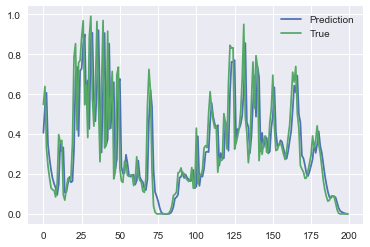

In [75]:
y_train_1 = ar_train_res.get_prediction().predicted_mean
y_test_1 = ar_test_res.get_prediction().predicted_mean
y_train_true = data_temp.iloc[:round(full_len*0.9),0].as_matrix()
y_test_true = data_temp.iloc[round(full_len*0.9) + 1:,0].as_matrix()

plt.plot(y_test_1 [-200:], label = 'Prediction')
plt.plot(y_test_true[-200:], label = 'True')
plt.legend()
print('Train 1 step ahead RMSE : {:f}'.format(np.sqrt(np.mean(np.square(y_train_true - y_train_1)))))
print('Test 1 step ahead RMSE : {:f}'.format(np.sqrt(np.mean(np.square(y_test_true - y_test_1)))))

Train 1 step ahead RMSE : 0.100241


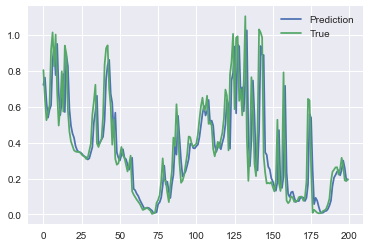

In [82]:
ar_test = sm.tsa.statespace.SARIMAX(data_temp.iloc[:,0].as_matrix(), order=(AR_order,0,0))
ar_test_res = ar_test.filter(ar_train_res.params)
y_train_1 = ar_train_res.get_prediction(dynamic = round(full_len*0.9)).predicted_mean
y_train_true = data_temp.iloc[:round(full_len*0.9),0].as_matrix()
print('Train 1 step ahead RMSE : {:f}'.format(np.sqrt(np.mean(np.square(y_train_true - y_train_1)))))

plt.plot(y_train_1 [-200:], label = 'Prediction')
plt.plot(y_train_true[-200:], label = 'True')
plt.legend()

# 3.1 Auto Regressive (AR)

In [99]:
def get_batch_AR(X, steps, cur_index):
    
    y = X[cur_index:cur_index+steps]
    
    return y

In [138]:
forecast_steps = 36
test_set_ratio = 0.05

AR_order = (1,0,0)       # p d q
Season_order = (0,0,0,0) # P D Q Lag
n_group = 0

data_temp = data_group_all[n_group]
full_len = data_group_all[n_group].shape[0]

len_train = round(full_len*(1-test_set_ratio))

data_train = data_temp.iloc[:len_train, 0].as_matrix()
data_test = data_temp.iloc[len_train+1:, 0].as_matrix()

# fit data only on the train data
ar_train = sm.tsa.statespace.SARIMAX(data_train, order=AR_order, seasonal_order=Season_order)
ar_train_res = ar_train.fit()
params = ar_train_res.params  # get train parameters

In [139]:
# evaluate of 3 hours steps forecast on train and dev set
data_train_temp = data_train.copy()
new_full_len = len_train
arr_y_dev = []

for k in range(0, len(data_test), forecast_steps):
    
    data_dev_temp = get_batch_AR(data_test, forecast_steps, k)
    data_train_temp = np.concatenate((data_train_temp, data_dev_temp))
    
    ar_test = sm.tsa.statespace.SARIMAX(data_train_temp, order=AR_order, seasonal_order=Season_order)
    ar_test_res = ar_test.filter(params)
    y_all_dev = ar_test_res.get_prediction(dynamic = new_full_len).predicted_mean
    
    y_dev = y_all_dev[-data_dev_temp.shape[0]:] # extract only last inserted test data
    arr_y_dev.extend(y_dev)
    
    new_full_len += data_dev_temp.shape[0]

# get predicted of train set
y_train = ar_train_res.get_prediction(dynamic = len_train - forecast_steps).predicted_mean
train_mse = np.sqrt(np.mean(np.square(np.array(y_train)[-forecast_steps:] - data_train[-forecast_steps:])))

dev_mse = np.sqrt(np.mean(np.square(np.array(arr_y_dev) - data_test)))

print('Train RMSE : {:6f} \nDev RMSE : {:6f}'.format(train_mse, dev_mse))

Train RMSE : 0.310595 
Dev RMSE : 0.323913


In [144]:
arr_train_mse = []
arr_dev_mse = []

for j in range(1, 30):
    forecast_steps = 36
    test_set_ratio = 0.05

    AR_order = (j,0,0)       # p d q
    Season_order = (0,0,0,0) # P D Q Lag
    n_group = 0

    data_temp = data_group_all[n_group]
    full_len = data_group_all[n_group].shape[0]

    len_train = round(full_len*(1-test_set_ratio))

    data_train = data_temp.iloc[:len_train, 0].as_matrix()
    data_test = data_temp.iloc[len_train+1:, 0].as_matrix()

    # fit data only on the train data
    ar_train = sm.tsa.statespace.SARIMAX(data_train, order=AR_order, seasonal_order=Season_order)
    ar_train_res = ar_train.fit()
    params = ar_train_res.params  # get train parameters

    # evaluate of 3 hours steps forecast on train and dev set
    data_train_temp = data_train.copy()
    new_full_len = len_train
    arr_y_dev = []

    for k in range(0, len(data_test), forecast_steps):

        data_dev_temp = get_batch_AR(data_test, forecast_steps, k)
        data_train_temp = np.concatenate((data_train_temp, data_dev_temp))

        ar_test = sm.tsa.statespace.SARIMAX(data_train_temp, order=AR_order, seasonal_order=Season_order)
        ar_test_res = ar_test.filter(params)
        y_all_dev = ar_test_res.get_prediction(dynamic = new_full_len).predicted_mean

        y_dev = y_all_dev[-data_dev_temp.shape[0]:] # extract only last inserted test data
        arr_y_dev.extend(y_dev)

        new_full_len += data_dev_temp.shape[0]

    # get predicted of train set
    y_train = ar_train_res.get_prediction(dynamic = len_train - forecast_steps).predicted_mean
    
    train_mse = np.sqrt(np.mean(np.square(np.array(y_train)[-forecast_steps:] - data_train[-forecast_steps:])))
    dev_mse = np.sqrt(np.mean(np.square(np.array(arr_y_dev) - data_test)))
    
    arr_train_mse.append(train_mse)
    arr_dev_mse.append(dev_mse)

    print('AR Order ({:d}, 0, 0)\nTrain RMSE : {:6f} \nDev RMSE : {:6f}'.format(j, train_mse, dev_mse))

AR Order (1, 0, 0)
Train RMSE : 0.310595 
Dev RMSE : 0.323913
AR Order (2, 0, 0)
Train RMSE : 0.300633 
Dev RMSE : 0.319975
AR Order (3, 0, 0)
Train RMSE : 0.284637 
Dev RMSE : 0.316353
AR Order (4, 0, 0)
Train RMSE : 0.274477 
Dev RMSE : 0.312604
AR Order (5, 0, 0)
Train RMSE : 0.266815 
Dev RMSE : 0.309978
AR Order (6, 0, 0)
Train RMSE : 0.264406 
Dev RMSE : 0.308993


D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AR Order (7, 0, 0)
Train RMSE : 0.260996 
Dev RMSE : 0.307563
AR Order (8, 0, 0)
Train RMSE : 0.259803 
Dev RMSE : 0.306314
AR Order (9, 0, 0)
Train RMSE : 0.259664 
Dev RMSE : 0.306100
AR Order (10, 0, 0)
Train RMSE : 0.259660 
Dev RMSE : 0.306026
AR Order (11, 0, 0)
Train RMSE : 0.259696 
Dev RMSE : 0.305656
AR Order (12, 0, 0)
Train RMSE : 0.260062 
Dev RMSE : 0.305039
AR Order (13, 0, 0)
Train RMSE : 0.260095 
Dev RMSE : 0.304995
AR Order (14, 0, 0)
Train RMSE : 0.260736 
Dev RMSE : 0.304700


D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AR Order (15, 0, 0)
Train RMSE : 0.260704 
Dev RMSE : 0.304715
AR Order (16, 0, 0)
Train RMSE : 0.260130 
Dev RMSE : 0.304884
AR Order (17, 0, 0)
Train RMSE : 0.261143 
Dev RMSE : 0.304617
AR Order (18, 0, 0)
Train RMSE : 0.261463 
Dev RMSE : 0.304517
AR Order (19, 0, 0)
Train RMSE : 0.261195 
Dev RMSE : 0.304609
AR Order (20, 0, 0)
Train RMSE : 0.260222 
Dev RMSE : 0.304955
AR Order (21, 0, 0)
Train RMSE : 0.260129 
Dev RMSE : 0.304983
AR Order (22, 0, 0)
Train RMSE : 0.260050 
Dev RMSE : 0.305003
AR Order (23, 0, 0)
Train RMSE : 0.259254 
Dev RMSE : 0.305144
AR Order (24, 0, 0)
Train RMSE : 0.257701 
Dev RMSE : 0.305756
AR Order (25, 0, 0)
Train RMSE : 0.257067 
Dev RMSE : 0.306156
AR Order (26, 0, 0)
Train RMSE : 0.256349 
Dev RMSE : 0.306865


D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AR Order (27, 0, 0)
Train RMSE : 0.255730 
Dev RMSE : 0.307438
AR Order (28, 0, 0)
Train RMSE : 0.255305 
Dev RMSE : 0.307821
AR Order (29, 0, 0)
Train RMSE : 0.255553 
Dev RMSE : 0.307596


In [97]:
len(data_test)

638

In [85]:
ar_train_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                12134
Model:               SARIMAX(6, 0, 0)   Log Likelihood               10613.928
Date:                Thu, 26 Oct 2017   AIC                         -21213.855
Time:                        20:16:23   BIC                         -21162.029
Sample:                             0   HQIC                        -21196.480
                              - 12134                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8535      0.005    160.260      0.000       0.843       0.864
ar.L2         -0.0387      0.007     -5.735      0.000      -0.052      -0.025
ar.L3          0.0561      0.007      8.278      0.000       0.043       0.069
ar.L4          0.0191      0.007      2.715      0.007       0.005       0.033
ar.L5          0.0595      0.007      8.295      0.000       0.045       0.074
ar.L6          0.0285      0.006      4.752      0.000       0.017       0.040
sigma2         0.0102   6.79e-05    149.815      0.000       0.010       0.010
===================================================================================
Ljung-Box (Q):                      117.15   Jarque-Bera (JB):             19708.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""